# Post-processing for OPF test cases

In this notebook, we will show how to post-process the results of the OPF test cases. The results are stored in the `results` folder. The model runs are in 2018. 

Includes the following scenarios:

1. Base case without renewable generation, stored in `results/wo_renew`.

2. Cases with renewable generation, stored in `results/w_renew`.

3. Cases with renewable generation and building electrification, stored in `results/w_renew_elec`.


## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle

import nygrid.run_nygrid as ng_run

plt.rcParams["font.family"] = "Times New Roman"


In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

renewable_data_dir = os.path.join(data_dir, 'renewable')
print('Renewable data directory: {}'.format(renewable_data_dir))

load_data_dir = os.path.join(data_dir, 'load')
print('Load data directory: {}'.format(load_data_dir))


Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results
Renewable data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable
Load data directory: /mnt/Bo_HDD/NYgrid-python/data/load


## Read grid data

In [4]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 12, 31, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


## Read OPF results

### 1. 2018Base

In [11]:
sim_name = '2018Baseline'
leading_hours = 12

grid_data_dir_2018 = os.path.join(data_dir, 'grid', '2018Baseline')
assert os.path.exists(grid_data_dir_2018), f'Grid data directory not found: {grid_data_dir_2018}'

sim_results_dir_2018 = os.path.join(results_dir, '2018Baseline')
assert os.path.exists(sim_results_dir_2018), f'Results directory not found: {sim_results_dir_2018}'

# Read load and generation profiles
grid_prop_2018 = ng_run.read_grid_prop(grid_data_dir_2018)
display(grid_prop_2018.keys())

grid_profile_2018 = ng_run.read_grid_profile(grid_data_dir_2018, year=2018)
display(grid_profile_2018.keys())

# Generator fuel types
display(grid_prop_2018['gen_fuel']['GEN_FUEL'].unique())


dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'gen_profile', 'genmax_profile', 'genmin_profile', 'genramp30_profile', 'gencost0_profile', 'gencost1_profile'])

array(['Combustion Turbine', 'Combined Cycle', 'Internal Combustion',
       'Steam Turbine', 'Jet Engine', 'Nuclear', 'Hydro', 'Import',
       'Wind', 'Other'], dtype=object)

In [13]:
# Loop through all days
results_list_2018 = []

for d in range(len(timestamp_list)):
    
    # Remove leading hours for the last day
    if d == len(timestamp_list) - 1:
        leading_hours = 0

    # Run OPF for one day (24 hours) plus leading hours
    # The first day is valid, the leading hours are used to dispatch batteries properly
    start_datetime = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name}_{start_datetime.strftime("%Y%m%d%H")}.pkl'
    with open(os.path.join(sim_results_dir_2018, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2018.append(results)

In [14]:
results_list_2018[0].keys()

dict_keys(['PG', 'PF', 'PL', 'IF', 'PBUS', 'esrPCrg', 'esrPDis', 'esrSOC', 'LMP', 's_ramp_up', 's_ramp_down', 's_over_gen', 's_load_shed', 's_if_max', 's_if_min', 's_br_max', 's_br_min', 'total_cost', 'gen_cost', 'over_gen_penalty', 'load_shed_penalty', 'ramp_up_penalty', 'ramp_down_penalty', 'if_max_penalty', 'if_min_penalty', 'br_max_penalty', 'br_min_penalty', 'esr_cost'])

In [16]:
def get_pg_by_fuel(pg_table, genfuel_list):
    """
    NOTE: This doesn't include Added DCline, ESR, and VRE.
    It only includes thermal generators and renewable generators
    that are defined in te gen_prop table.
    """

    fuel_types = genfuel_list.unique()
    pg_by_fuel = dict()

    for fuel_type in fuel_types:
        fuel_idx = np.where(genfuel_list == fuel_type)[0]
        fuel_pg = pg_table.iloc[:, fuel_idx]
        fuel_pg = fuel_pg.iloc[:24, :]

        pg_by_fuel[fuel_type] = fuel_pg

    return pg_by_fuel


In [18]:
# Thermal generator power output
thermal_pg_list_2018 = list()
pg_by_fuel_dict_2018 = dict()

for d in range(len(timestamp_list)):
    # Get thermal generator power output
    thermal_pg = results_list_2018[d]['PG'].iloc[:,:num_thermal].rename(columns=gen_rename)
    thermal_pg = thermal_pg.iloc[:24, :]
    thermal_pg_list_2018.append(thermal_pg)

    # Get power output by fuel type
    pg_by_fuel = get_pg_by_fuel(pg_table=results_list_2018[d]['PG'],
                                genfuel_list=grid_prop_2018['gen_prop']['GEN_FUEL'])

    for fuel_type in pg_by_fuel.keys():
        if fuel_type not in pg_by_fuel_dict_2018:
            pg_by_fuel_dict_2018[fuel_type] = list()

        pg_by_fuel_dict_2018[fuel_type].append(pg_by_fuel[fuel_type])

thermal_pg_2018Baseline = pd.concat(thermal_pg_list_2018)

for fuel_type in pg_by_fuel_dict_2018.keys():
    pg_by_fuel_dict_2018[fuel_type] = pd.concat(pg_by_fuel_dict_2018[fuel_type])

In [22]:
grid_prop_2018['gen_prop']

,GEN_NAME,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,...,QC1MX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,GEN_ZONE,GEN_FUEL
0,59 St. GT 1,82,0.000000,0.0,9999,-9999,1.0,100,1,17.100000,...,0,0,0,1.71,17.1,17.1,0,0,J,Combustion Turbine
1,74 St. GT 1,82,0.000000,0.0,9999,-9999,1.0,100,1,18.500000,...,0,0,0,1.85,18.5,18.5,0,0,J,Combustion Turbine
2,74 St. GT 2,82,0.000000,0.0,9999,-9999,1.0,100,1,18.500000,...,0,0,0,1.85,18.5,18.5,0,0,J,Combustion Turbine
3,Allegany,62,0.000000,0.0,9999,-9999,1.0,100,1,66.000000,...,0,0,0,6.60,66.0,66.0,0,0,B,Combined Cycle
4,Allied Frozen Storage,55,0.000000,0.0,9999,-9999,1.0,100,1,0.100000,...,0,0,0,0.01,0.1,0.1,0,0,A,Internal Combustion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Other_F_3,37,7.465825,0.0,9999,-9999,1.0,100,1,7.465825,...,0,0,0,0.00,0.0,0.0,0,0,F,Other
299,Other_G_0,73,5.723800,0.0,9999,-9999,1.0,100,1,5.723800,...,0,0,0,0.00,0.0,0.0,0,0,G,Other
300,Other_H_0,74,37.142482,0.0,9999,-9999,1.0,100,1,37.142482,...,0,0,0,0.00,0.0,0.0,0,0,H,Other
301,Other_K_0,79,76.898002,0.0,9999,-9999,1.0,100,1,76.898002,...,0,0,0,0.00,0.0,0.0,0,0,K,Other


In [29]:
# ESR power output
ii = 6
crg_max = grid_prop_2018['esr_prop']['ESR_CRG_MAX'].iloc[ii]
dis_max = grid_prop_2018['esr_prop']['ESR_DIS_MAX'].iloc[ii]
crg_eff = grid_prop_2018['esr_prop']['ESR_CRG_EFF'].iloc[ii]
dis_eff = grid_prop_2018['esr_prop']['ESR_DIS_EFF'].iloc[ii]
soc_init = grid_prop_2018['esr_prop']['ESR_SOC_INI'].iloc[ii]
soc_max = grid_prop_2018['esr_prop']['ESR_SOC_MAX'].iloc[ii]

print(f'crg_max: {crg_max}, dis_max: {dis_max}, crg_eff: {crg_eff}, dis_eff: {dis_eff}, soc_init: {soc_init}, soc_max: {soc_max}')


crg_max: 2.0, dis_max: 2.0, crg_eff: 0.85, dis_eff: 0.85, soc_init: 4, soc_max: 8


Text(0.5, 0.98, 'Day 1 w/o IC')

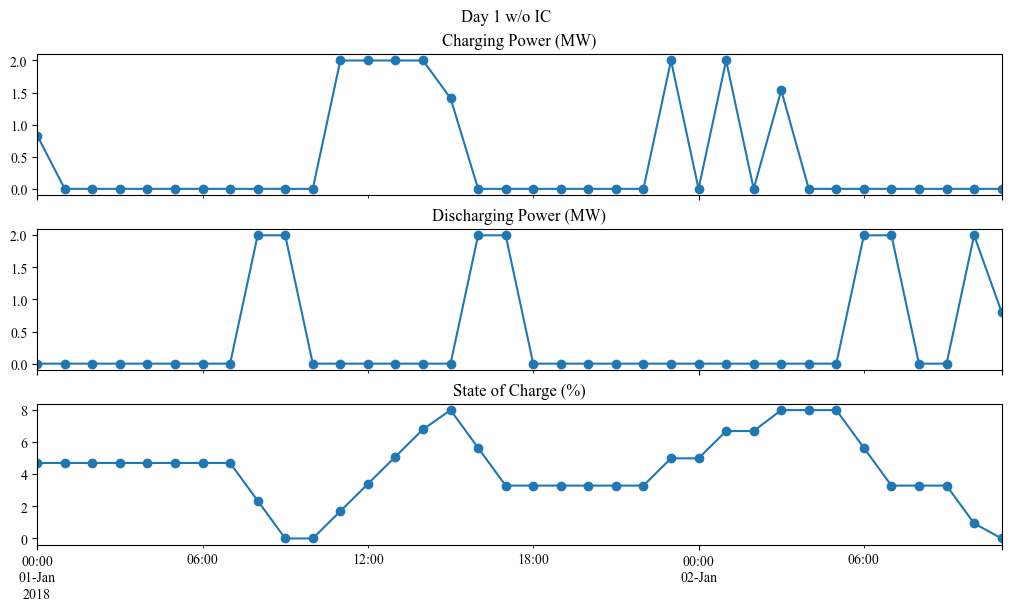

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6),
                       sharex=True, layout='constrained')

results_list_2018[0]['esrPCrg'].iloc[:, ii].plot(title='Charging Power (MW)',
                                            ax=ax[0], marker='o')
results_list_2018[0]['esrPDis'].iloc[:, ii].plot(title='Discharging Power (MW)',
                                            ax=ax[1], marker='o')
results_list_2018[0]['esrSOC'].iloc[:, ii].plot(title='State of Charge (%)',
                                           ax=ax[2], marker='o')
fig.suptitle('Day 1 w/o IC')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

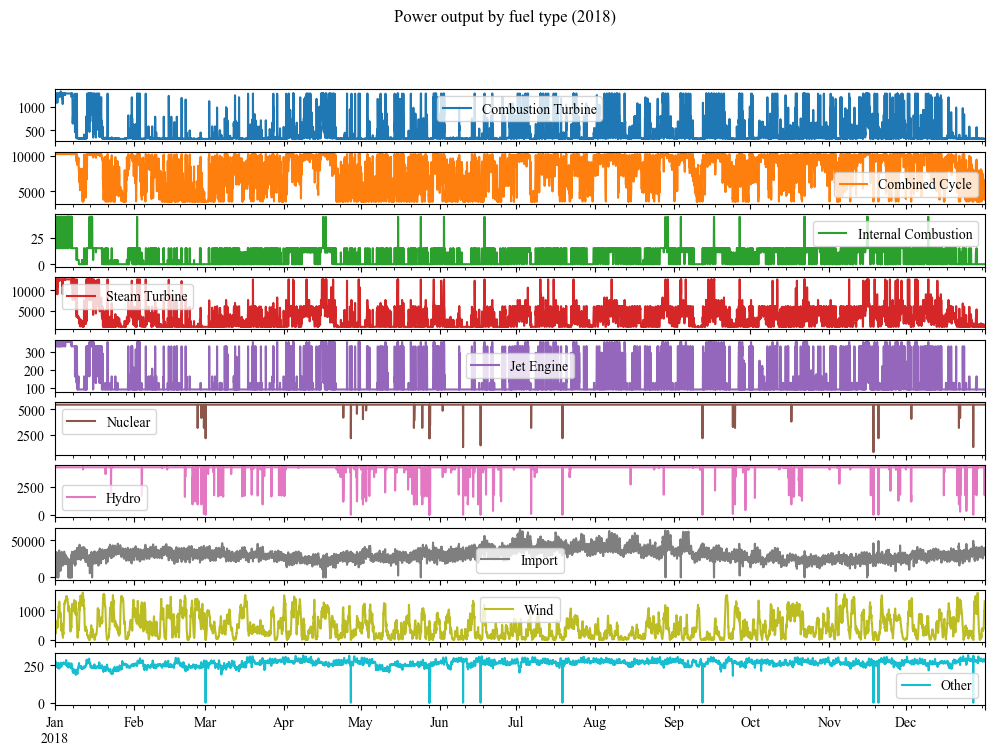

In [19]:
pg_by_fuel_sum_2018 = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2018.items():
    pg_by_fuel_sum_2018[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_2018 = pd.DataFrame(pg_by_fuel_sum_2018,
                              index=pg_by_fuel_dict_2018['Wind'].index)

pg_by_fuel_sum_2018.plot(subplots=True, figsize=(12, 8), title='Power output by fuel type (2018)')

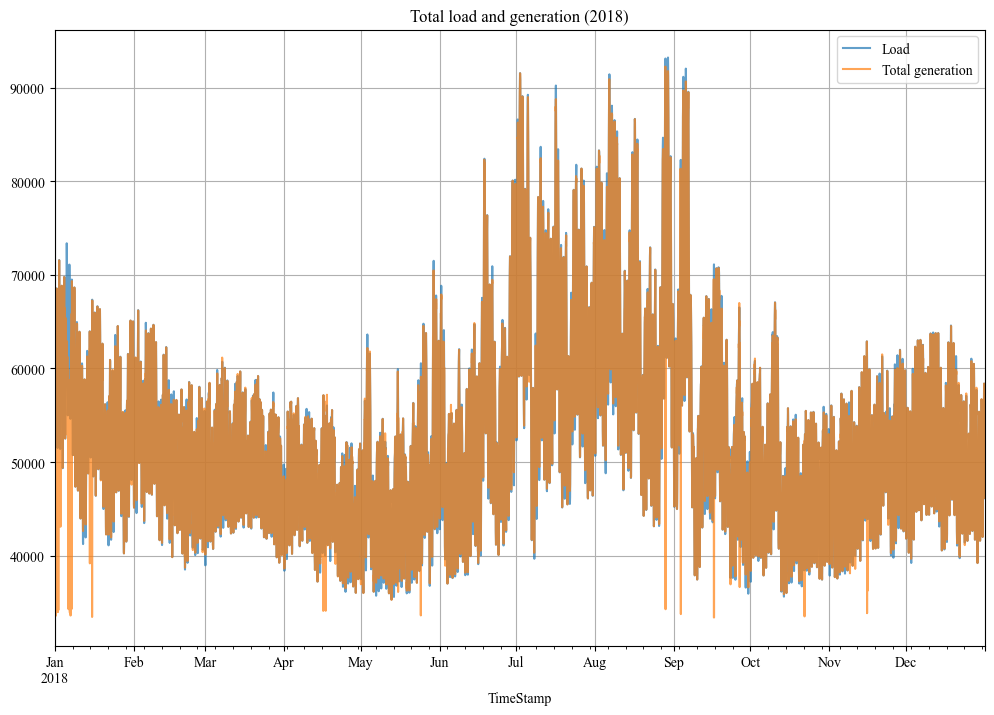

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
grid_profile_2018['load_profile'].sum(axis=1).plot(label='Load', alpha=0.7)
pg_by_fuel_sum_2018.sum(axis=1).plot(label='Total generation', alpha=0.7)
plt.legend()
plt.title('Total load and generation (2018)')
plt.grid()
plt.show()

In [15]:
thermal_pg_2018Baseline.to_csv(os.path.join(results_dir, 'thermal_pg_2018Baseline.csv'))

In [16]:
lmp_list_2018 = []

for d in range(len(timestamp_list)):
    # Get LMP
    lmp = results_list_2018[d]['LMP']
    lmp = lmp.iloc[:24, :]
    lmp_list_2018.append(lmp)

lmp_2018Baseline = pd.concat(lmp_list_2018)

### 2. 2030CLCPA

In [17]:
sim_name = '2030CLCPA_0.3'
leading_hours = 12

grid_data_dir = os.path.join(data_dir, 'grid', '2030CLCPA')
assert os.path.exists(grid_data_dir), f'Grid data directory not found: {grid_data_dir}'

sim_results_dir = os.path.join(results_dir, '2030CLCPA_0.3')
assert os.path.exists(sim_results_dir), f'Results directory not found: {sim_results_dir}'

In [18]:
# Loop through all days
results_list_2030 = []

for d in range(len(timestamp_list)):
    
    # Remove leading hours for the last day
    if d == len(timestamp_list) - 1:
        leading_hours = 0

    # Run OPF for one day (24 hours) plus leading hours
    # The first day is valid, the leading hours are used to dispatch batteries properly
    start_datetime = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name}_{start_datetime.strftime("%Y%m%d%H")}.pkl'
    with open(os.path.join(sim_results_dir, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030.append(results)

In [19]:
results_list_2030[0].keys()

dict_keys(['PG', 'PF', 'PL', 'IF', 'PBUS', 'esrPCrg', 'esrPDis', 'esrSOC', 'LMP', 's_ramp_up', 's_ramp_down', 's_over_gen', 's_load_shed', 's_if_max', 's_if_min', 's_br_max', 's_br_min', 'total_cost', 'gen_cost', 'over_gen_penalty', 'load_shed_penalty', 'ramp_up_penalty', 'ramp_down_penalty', 'if_max_penalty', 'if_min_penalty', 'br_max_penalty', 'br_min_penalty', 'esr_cost'])

In [20]:
# Read load and generation profiles
grid_prop = ng_run.read_grid_prop(grid_data_dir)
grid_prop.keys()

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

In [21]:
# Thermal generator power output
thermal_pg_list_2030 = list()
pg_by_fuel_dict_2030 = dict()

for d in range(len(timestamp_list)):
    # Get thermal generator power output
    thermal_pg = results_list_2030[d]['PG'].iloc[:,:num_thermal].rename(columns=gen_rename)
    thermal_pg = thermal_pg.iloc[:24, :]
    thermal_pg_list_2030.append(thermal_pg)

    # Get power output by fuel type
    pg_by_fuel = get_pg_by_fuel(pg_table=results_list_2030[d]['PG'],
                                genfuel_list=grid_prop['gen_fuel']['GEN_FUEL'])

    for fuel_type in pg_by_fuel.keys():
        if fuel_type not in pg_by_fuel_dict_2030:
            pg_by_fuel_dict_2030[fuel_type] = list()

        pg_by_fuel_dict_2030[fuel_type].append(pg_by_fuel[fuel_type])

thermal_pg_2030CLCPA = pd.concat(thermal_pg_list_2030)

for fuel_type in pg_by_fuel_dict_2030.keys():
    pg_by_fuel_dict_2030[fuel_type] = pd.concat(pg_by_fuel_dict_2030[fuel_type])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

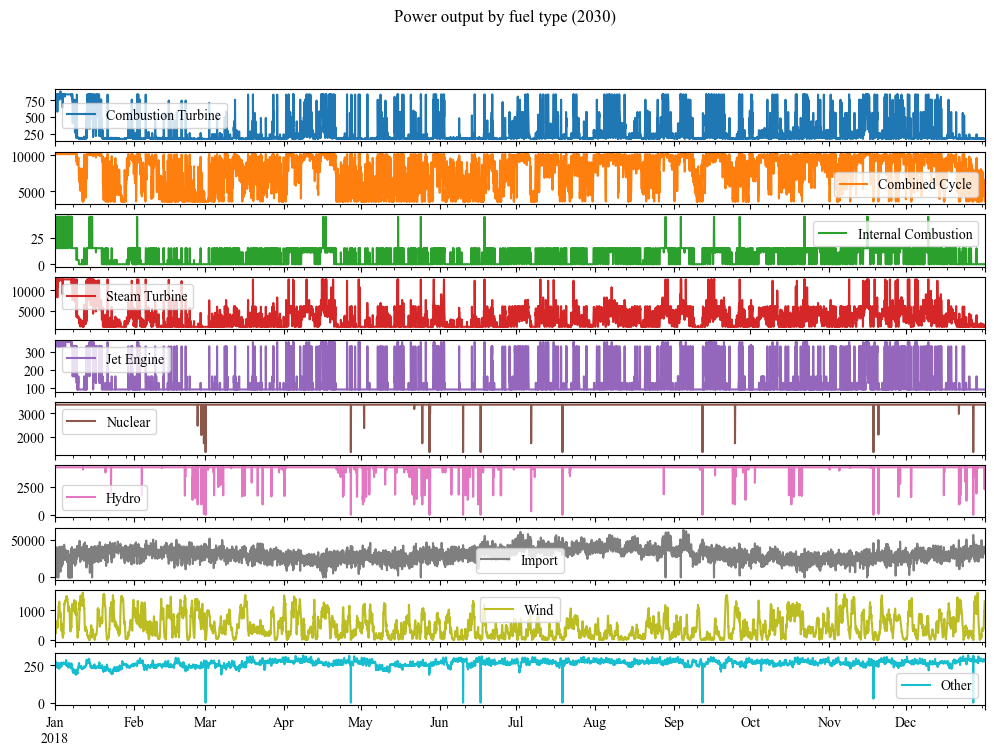

In [22]:
pg_by_fuel_sum = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    pg_by_fuel_sum[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum = pd.DataFrame(pg_by_fuel_sum,
                              index=pg_by_fuel_dict_2018['Wind'].index)

pg_by_fuel_sum.plot(subplots=True, figsize=(12, 8), title='Power output by fuel type (2030)')

In [23]:
thermal_pg_2030CLCPA.to_csv(os.path.join(results_dir, 'thermal_pg_2030CLCPA_0.3.csv'))

In [24]:
lmp_list_2030 = []

for d in range(len(timestamp_list)):
    # Get LMP
    lmp = results_list_2030[d]['LMP']
    lmp = lmp.iloc[:24, :]
    lmp_list_2030.append(lmp)

lmp_2030CLCPA = pd.concat(lmp_list_2030)

## Calculate heat input

In [25]:
# Heat input linear model
heat_rate_lm = gen_info[['HeatRateLM_1', 'HeatRateLM_0']].to_numpy()

heat_input_2018Baseline = pd.DataFrame(index=thermal_pg_2018Baseline.index)
heat_input_2030CLCPA = pd.DataFrame(index=thermal_pg_2030CLCPA.index)

# Loop through all thermal generators
for i in range(num_thermal):
    # Get heat rate linear model
    heat_rate_lm_i = heat_rate_lm[i, :]
    
    # Get thermal generation profiles
    thermal_pg_2018Baseline_i = thermal_pg_2018Baseline[gen_rename[i]]
    thermal_pg_2030CLCPA_i = thermal_pg_2030CLCPA[gen_rename[i]]

    # Get heat input
    heat_input_2018Baseline_i = heat_rate_lm_i[0] * thermal_pg_2018Baseline_i + heat_rate_lm_i[1]
    heat_input_2030CLCPA_i = heat_rate_lm_i[0] * thermal_pg_2030CLCPA_i + heat_rate_lm_i[1]

    # Add to dataframe
    heat_input_2018Baseline = pd.concat([heat_input_2018Baseline, heat_input_2018Baseline_i], axis=1)
    heat_input_2030CLCPA = pd.concat([heat_input_2030CLCPA, heat_input_2030CLCPA_i], axis=1)
    

In [26]:
# Save to csv
heat_input_2018Baseline.to_csv(os.path.join(results_dir, 'heat_input_2018Baseline.csv'))
heat_input_2030CLCPA.to_csv(os.path.join(results_dir, 'heat_input_2030CLCPA_0.3.csv'))

## Plotting

In [27]:
if not os.path.exists(os.path.join(fig_dir, 'thermal_pg')):
    os.makedirs(os.path.join(fig_dir, 'thermal_pg'))


In [28]:
# Representative weeks
season_list = ['Winter', 'Spring', 'Summer', 'Autumn']

winter_week = ['2018-01-01', '2018-01-07']
spring_week = ['2018-04-02', '2018-04-08']
summer_week = ['2018-07-02', '2018-07-08']
autumn_week = ['2018-10-01', '2018-10-07']

week_list = [winter_week, spring_week, summer_week, autumn_week]

### Total

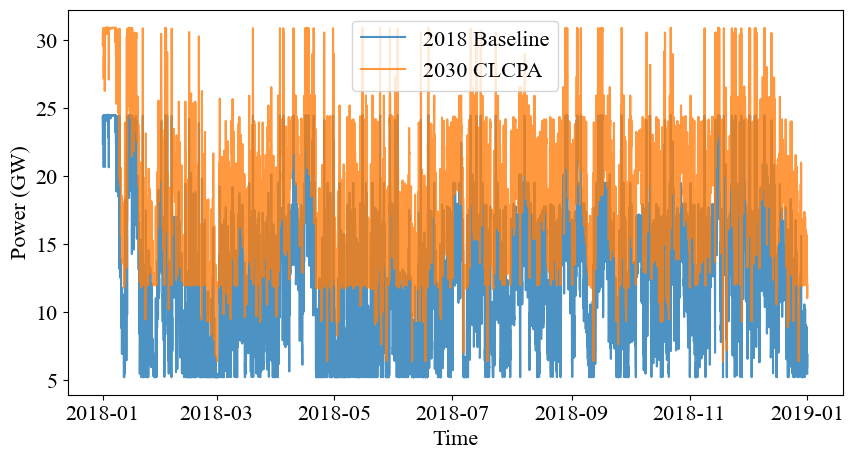

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(thermal_pg_2018Baseline.sum(axis=1)/1e3, alpha=0.8, label='2018 Baseline')
ax.plot(thermal_pg_2030CLCPA.sum(axis=1)/1e3, alpha=0.8, label='2030 CLCPA')

ax.set_ylabel('Power (GW)', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.png'), 
#             dpi=600, bbox_inches='tight', format='png')
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.svg'), 
#             bbox_inches='tight', format='svg')


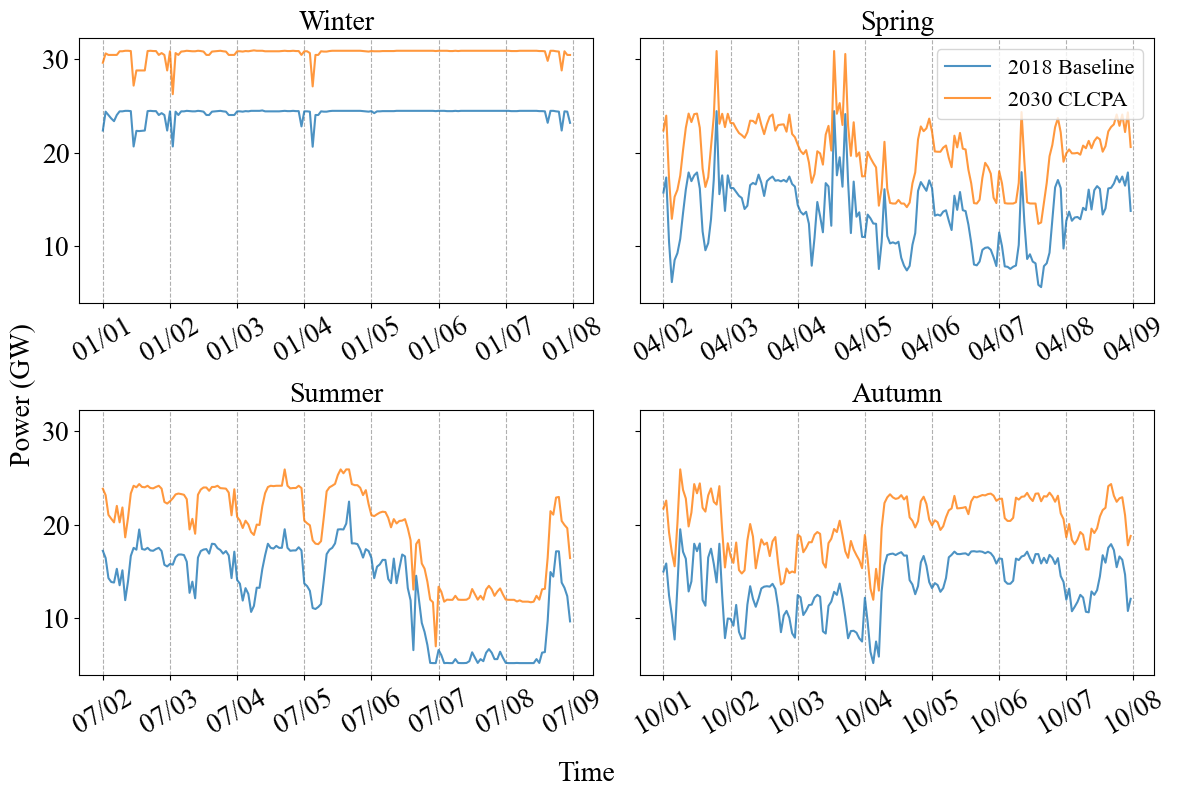

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8),
                        sharex=False, sharey=True)

for i in range(4):
    ax = axs.flatten()[i]
    
    ax.plot(1/1e3*thermal_pg_2018Baseline.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='2018 Baseline')
    ax.plot(1/1e3*thermal_pg_2030CLCPA.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='2030 CLCPA')

    # Formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
    # ax.set_ylim(0, 30)
    ax.tick_params(axis='x', rotation=30)
    ax.set_title(season_list[i], fontsize=20)
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=20)
    if i == 1:
            ax.legend(fontsize=16, loc='upper right')


fig.supxlabel('Time', fontsize=20)
fig.supylabel('Power (GW)', fontsize=20)
# title = 'Total thermal generation in NYS'
# fig.suptitle(title, fontsize=24)
plt.tight_layout()
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
#             dpi=600, bbox_inches='tight', format='png')
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
#             bbox_inches='tight', format='svg')

### Individual generators

In [31]:
# for ii in range(num_thermal):

#     gen_name = gen_info.NYISOName[ii]
#     fig, axs = plt.subplots(2, 2, figsize=(12, 8),
#                         sharex=False, sharey=True)

#     for i in range(4):
#         ax = axs.flatten()[i]
        
#         ax.plot(thermal_pg_2018Baseline.loc[week_list[i][0]:week_list[i][1], gen_name], 
#                 alpha=0.8, label='2018 Baseline')
#         ax.plot(thermal_pg_2030CLCPA.loc[week_list[i][0]:week_list[i][1], gen_name], 
#                 alpha=0.8, label='2030 CLCPA')

#         # Formatting
#         ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
#         ax.tick_params(axis='x', rotation=30)
#         ax.set_title(season_list[i], fontsize=20)
#         ax.grid(axis='x', linestyle='--')
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         if i == 3:
#                 ax.legend(fontsize=16, loc='upper right',
#                           ncol=2, frameon=True)

#     fig.supxlabel('Time', fontsize=20)
#     fig.supylabel('Power (MW)', fontsize=20)
#     title = f'{gen_info.NYISOName[ii]} ({gen_info.UnitType[ii]}, Zone {gen_info.Zone[ii]})'
#     fig.suptitle(title, fontsize=24)
#     plt.tight_layout()
#     gen_name_str = gen_name.replace('/', '_')
#     fig.savefig(os.path.join(fig_dir, 'thermal_pg', f'{gen_name_str}.png'), dpi=300)
#     plt.close()

### LMP

In [32]:
# Read bus properties
filename = os.path.join(grid_data_dir, "bus_prop.csv")
bus_prop = pd.read_csv(filename)

# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = bus_prop.set_index("BUS_I").to_dict()["BUS_ZONE"]
bus_names = list(bus_zone_alloc.keys())

lmp_2018Baseline.columns = bus_names
lmp_2030CLCPA.columns = bus_names

# Aggregate LMPs by zone
zonal_lmp_2018Baseline = lmp_2018Baseline.T.groupby(bus_zone_alloc).mean().T
zonal_lmp_2030CLCPA = lmp_2030CLCPA.T.groupby(bus_zone_alloc).mean().T

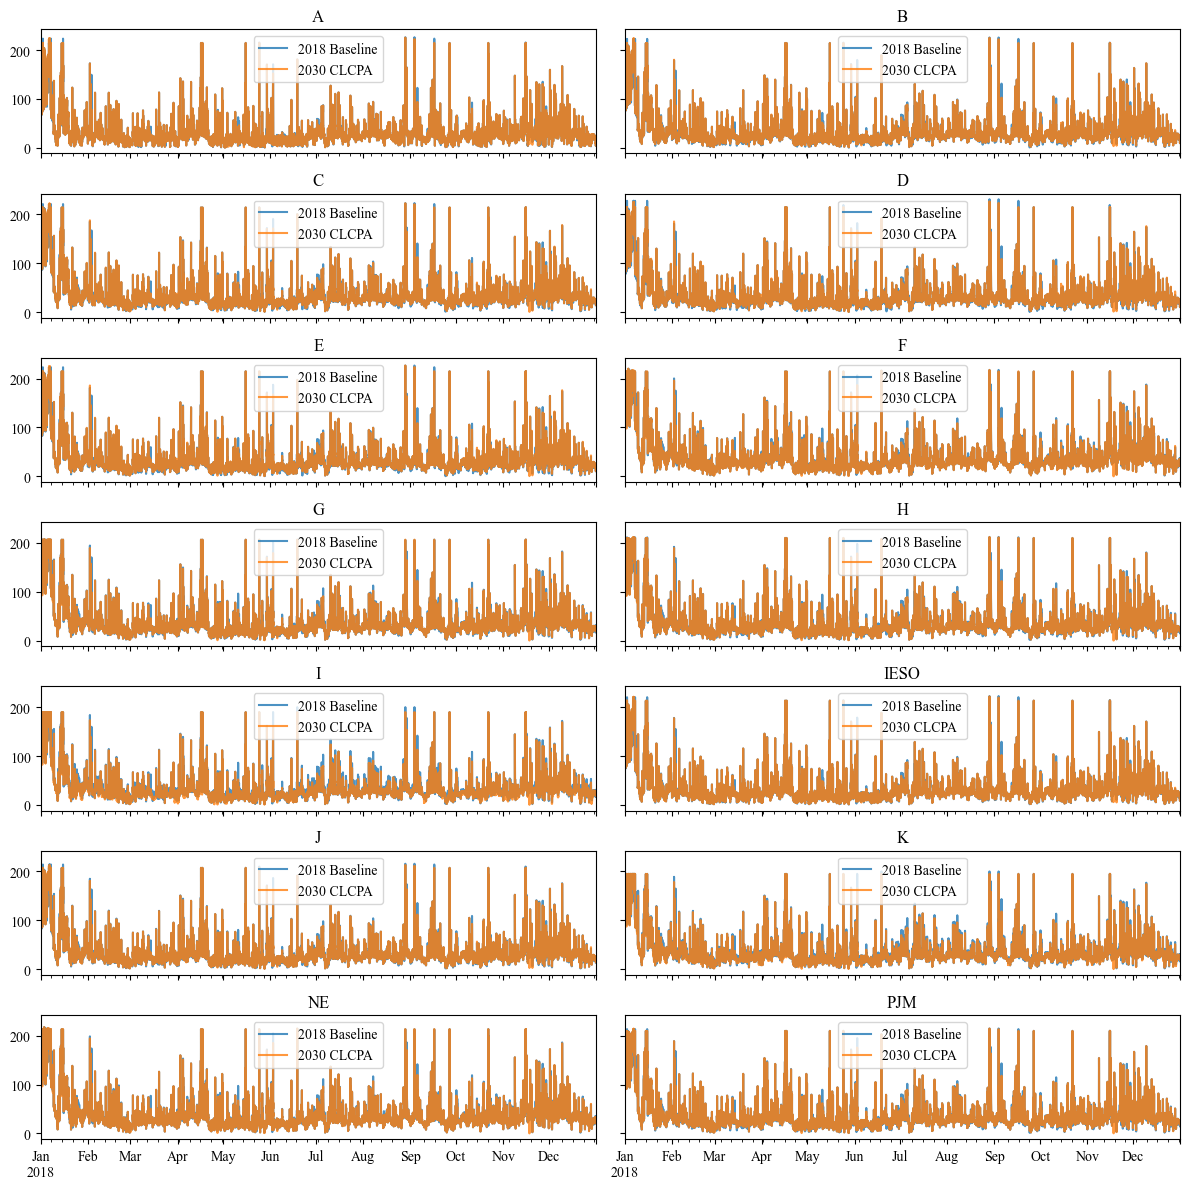

In [40]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
                        sharex='all', sharey='all')

for i, ax in enumerate(axs.flat):
    zonal_lmp_2018Baseline.iloc[:, i].plot(ax=ax, label='2018 Baseline', alpha=0.8)
    zonal_lmp_2030CLCPA.iloc[:, i].plot(ax=ax, label='2030 CLCPA', alpha=0.8)
    ax.set_title(zonal_lmp_2018Baseline.columns[i])
    ax.legend()

fig.tight_layout()

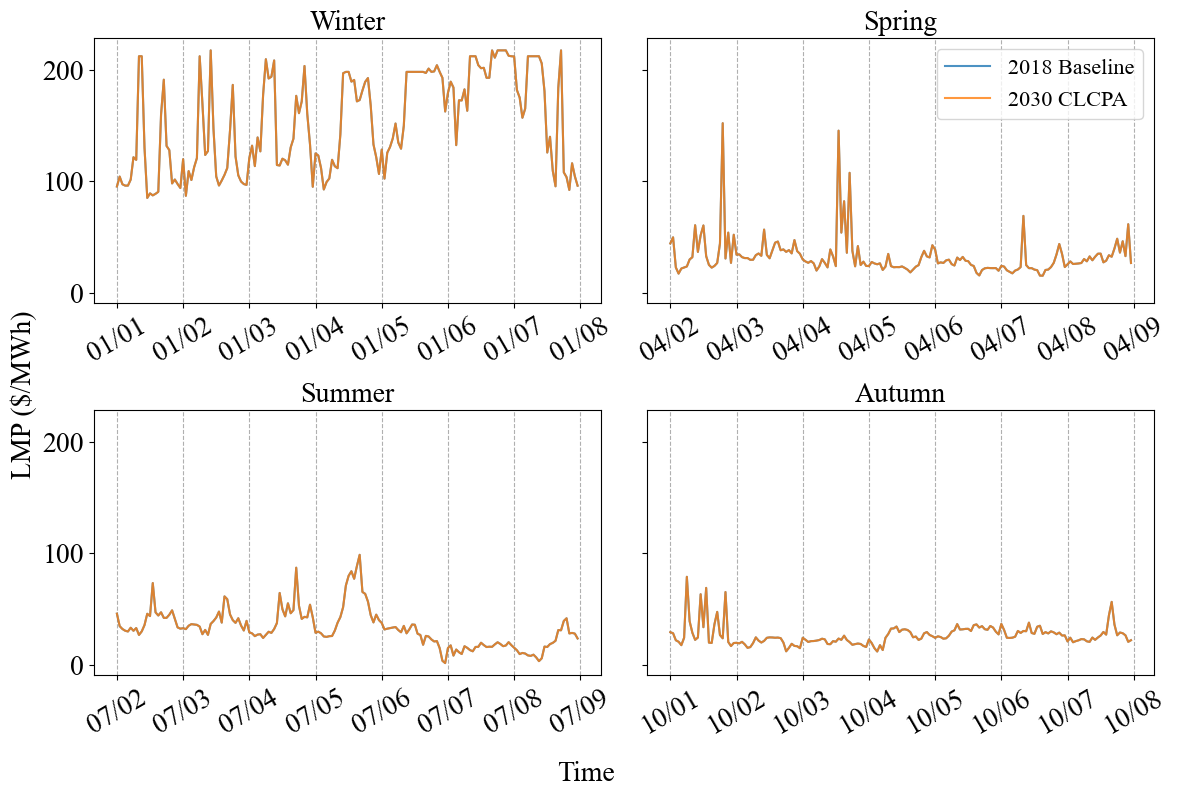

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8),
                        sharex=False, sharey=True)

for i in range(4):
    ax = axs.flatten()[i]
    
    ax.plot(lmp_2018Baseline.mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='2018 Baseline')
    ax.plot(lmp_2018Baseline.mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='2030 CLCPA')

    # Formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
    # ax.set_ylim(0, 30)
    ax.tick_params(axis='x', rotation=30)
    ax.set_title(season_list[i], fontsize=20)
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=20)
    if i == 1:
            ax.legend(fontsize=16, loc='upper right')


fig.supxlabel('Time', fontsize=20)
fig.supylabel('LMP ($/MWh)', fontsize=20)
# title = 'Total thermal generation in NYS'
# fig.suptitle(title, fontsize=24)
plt.tight_layout()
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
#             dpi=600, bbox_inches='tight', format='png')
# fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
#             bbox_inches='tight', format='svg')